In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
#import glob

In [15]:
#Load the COSMOS shape catalog information 
redshift_distribution = np.load("/Users/jw/Documents/cGAN_project_1/rcGAN/cosmos/hist_n_z.npy", allow_pickle=True)

# It appears data is already normalised.

In [4]:
redshift_vals_array = np.array((0, 
                 0.034, 0.070, 0.105, 0.142, 0.179,
                 0.216, 0.255, 0.294, 0.335, 0.376,
                 0.418, 0.462, 0.506, 0.552, 0.599,
                 0.648, 0.698, 0.749, 0.803, 0.858,
                 0.914, 0.973, 1.034, 1.097, 1.163,
                 1.231, 1.302, 1.375, 1.452, 1.532,
                 1.615, 1.703, 1.794, 1.889, 1.989,
                 2.094, 2.203, 2.319, 2.440, 2.568,
                 2.605, 2.642, 2.679,
                 2.716, 2.755, 2.794, 2.835, 2.876,
                 2.918, 2.962, 3.006, 3.052, 3.099,
                 3.148, 3.198, 3.249, 3.303, 3.358,
                 3.414, 3.473, 3.534, 3.597, 3.663,
                 3.731, 3.802, 3.875, 3.952, 4.032,
                 4.115, 4.203, 4.294, 4.389, 4.489,
                 4.594, 4.703, 4.819, 4.940, 5.068))

#TODO: Is this an acceptable way to extend the redshift values (prev + 2.5).

In [100]:
len(redshift_vals_array)

79

In [121]:
z = np.arange(0, 5.5, .01)


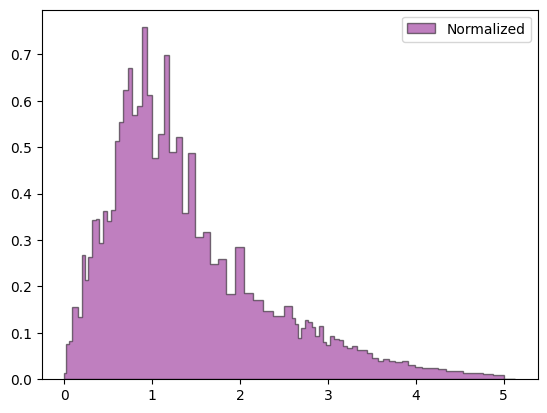

In [125]:
bin_edges = np.concatenate([[0], [(redshift_vals_array[i] - redshift_vals_array[i-1])/2 + redshift_vals_array[i-1] for i in range(1, len(redshift_vals_array))],
                            [redshift_vals_array[-1] + (redshift_vals_array[-1] - redshift_vals_array[-2])/2]])
# Create a histogram using your specified bin edges
hist, bin_edges, _ = plt.hist(z, weights=redshift_distribution, bins=bin_edges, color="purple", alpha=0.5, ec="k", histtype='stepfilled', density=True, label='Normalized')
plt.legend()
plt.show()
#bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
## Print the bin edges and central values
# for i, (edge, center, value) in enumerate(zip(bin_edges, bin_centers, hist)):
#     print(f"Bin {i + 1}: Edge: {edge}, Center: {center}, Value: {value}")
pdf = hist

In [126]:
len(hist)

79

In [19]:
area_under_normalized_curve = np.trapz(redshift_distribution, z)
print(f"Area under the normalized curve: {area_under_normalized_curve}")

min_value = np.min(redshift_distribution)
max_value = np.max(redshift_distribution)
normalised_data = (redshift_distribution - min_value) / (max_value - min_value)
print(np.trapz(normalised_data, z))

#TODO: Normalise correctly - appears normalised in histogram but not data



Area under the normalized curve: 4195.5308383997
0.887433467615968


In [20]:
source_dir = "/Users/jw/Documents/LP006/run001/" 

#source_dir = "/Users/jw/Documents/LP006/run*/" # TODO: Switch to this after debugging.

file_prefix = "kappa"
file_extension = ".dat"

# List all files in the folder
files = os.listdir(source_dir)

required_files = [file for file in files if file.startswith(file_prefix) and file.endswith(file_extension)]

def get_file_number(file_name):
    return int(file_name[len(file_prefix):-len(file_extension)])

#The files are now ordered in ascending redshift.
sorted_files = sorted(required_files, key=get_file_number)

In [128]:
img_num = 0
kappa_tot = np.zeros((1024, 1024))

#for fname in sorted_files:
for fname in range(len(redshift_vals_array)): #We will repeat this process for every source redshift.
    if fname in range(0, 41):
        full_path = os.path.join(source_dir, sorted_files[fname])
    else:
        # Uses z=2.6 map (with appropriate weight) for redshifts beyond kappaTNG range.
        full_path = os.path.join(source_dir, sorted_files[40])

    if not os.path.exists(full_path):
        print(f'The file at {full_path} does not exist.')
    else:
        with open(full_path, 'rb') as f:
            # Load file
            #print(f"loading z = {redshift_vals_array[fname]}...")
            dummy = np.fromfile(f, dtype="int32", count=1)
            kappa = np.fromfile(f, dtype="float", count=1024*1024)
            dummy = np.fromfile(f, dtype="int32", count=1)  

            kappa = kappa.reshape((1024, 1024))

            # Bin size halved for first and last bins.
            # delta_z is the range of each bin.
            if img_num == 0:
                delta_z = redshift_vals_array[img_num + 1] - redshift_vals_array[img_num]
        
            elif img_num == len(redshift_vals_array) - 1:
                delta_z = redshift_vals_array[img_num] - redshift_vals_array[img_num - 1]

            else:
                delta_z = redshift_vals_array[img_num + 1] - redshift_vals_array[img_num - 1]
            
            omega = pdf[img_num] * delta_z

            kappa_tot += omega * kappa
            
            img_num +=1

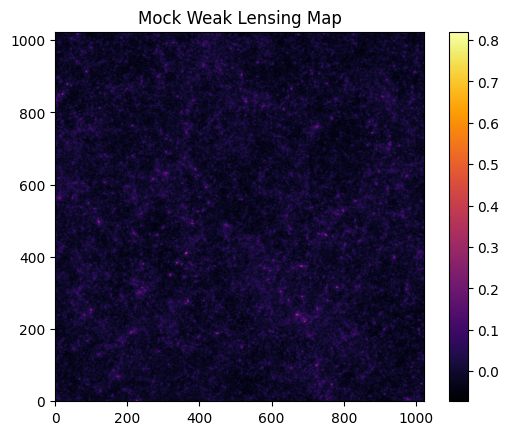

In [94]:
plt.imshow(kappa_tot, cmap = "inferno", origin="lower")
plt.colorbar()
plt.title("Mock Weak Lensing Map")
plt.show()

In [129]:
#TODO: Import these rather than rewriting functions.

def compute_fourier_kernel(N: int) -> np.ndarray:
  """Computes the Fourier space kernel which represents the mapping between 
    convergence (kappa) and shear (gamma).
  Args:
    N (int): x,y dimension of image patch (assumes square images).
  Returns:
    𝒟 (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
  """
  # Generate grid of Fourier domain
  kx = np.arange(N).astype(np.float64) - N/2
  ky, kx = np.meshgrid(kx, kx)
  k = kx**2+ky**2
  # Define Kaiser-Squires kernel
  𝒟 = np.zeros((N, N), dtype=np.complex128)
  𝒟 = np.where(k > 0, ((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))/k, 𝒟)
  # Apply inverse FFT shift 
  return np.fft.ifftshift(𝒟)


def forward_model(𝜅: np.ndarray, 𝒟: np.ndarray) -> np.ndarray:
  """Applies the forward mapping between convergence and shear through their 
    relationship in Fourier space.
  Args:
    𝜅 (np.ndarray): Convergence field, with shape [N,N].
    𝒟 (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
  Returns:
    γ (np.ndarray): Shearing field, with shape [N,N].
  """
  𝓕𝜅 = np.fft.fft2(𝜅) # Perform 2D forward FFT
  𝓕γ = 𝓕𝜅 * 𝒟 # Map convergence onto shear
  return np.fft.ifft2(𝓕γ) # Perform 2D inverse FFT


def noise_maker(theta, ngrid, ngal, kappa):
    """Adds some random Gaussian noise to a mock weak lensing map.
    Args:
        theta (float): Opening angle in deg.
        ngrid (int): Number of grids.
        ngal (int): Number of galaxies.
        kappa (np.ndarray): Convergence map.
    
    Returns:
        gamma (np.ndarray): A synthetic representation of the shear field, gamma, with added noise.
    """
    D = compute_fourier_kernel(ngrid) #Fourier kernel
    sigma = 0.37/np.sqrt(((theta*60/ngrid)**2)*ngal)
    gamma = forward_model(kappa, D) + sigma*(np.random.randn(ngrid,ngrid) + 1j*np.random.randn(ngrid,ngrid))
    return gamma

/var/folders/6b/03s1_j_j7hxcy34z8hkmlj140000gp/T/ipykernel_4535/3179233599.py:15: RuntimeWarning: invalid value encountered in divide
  𝒟 = np.where(k > 0, ((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))/k, 𝒟)


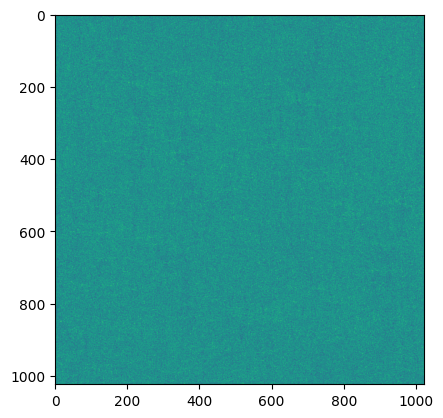

In [135]:
gamma = noise_maker(5.0, 1024, 30, kappa_tot)
plt.imshow(gamma.real)
plt.show()